In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import keras.backend as K
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import *
from keras.losses import *
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io
import skimage.transform as tr
import skimage.color
from sklearn.metrics import classification_report
from glob import glob

## Own Scripts
from helper import * 
from loss_metrics import *
from unet import *


In [25]:
# initialise train data
train_size = 18300
val_size = 3922
test_size = 3922
batch_size = 32
dsPath = '/home/dan/Desktop/Datenset_Block3'
epochs = 40

In [26]:
# create generators for training 

trainInputPath = dsPath + '/train/images'
trainOutputPath = dsPath + '/train/masks'

valInputPath = dsPath + '/validate/images'
valOutputPath = dsPath + '/validate/masks'

trainGen = loadData(trainInputPath, trainOutputPath, batch_size)
valGen   = loadData(valInputPath, valOutputPath, batch_size)

In [27]:
# initialise new model
model = None
model = UNet((224,224,1), 1, 16, 5, 2.0, batchnorm = True)
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            (None, 224, 224, 1)  0                                            
__________________________________________________________________________________________________
conv2d_121 (Conv2D)             (None, 224, 224, 16) 160         input_6[0][0]                    
__________________________________________________________________________________________________
batch_normalization_95 (BatchNo (None, 224, 224, 16) 64          conv2d_121[0][0]                 
__________________________________________________________________________________________________
conv2d_122 (Conv2D)             (None, 224, 224, 16) 2320        batch_normalization_95[0][0]     
__________________________________________________________________________________________________
batch_norm

In [8]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

ImportError: Failed to import `pydot`. Please install `pydot`. For example with `pip install pydot`.

In [7]:
# load trained Model  
from keras.models import load_model 
model = load_model('ds_step08.h5', custom_objects={'iou_loss': iou_loss})
model.summary()

OSError: Unable to open file (unable to open file: name = 'ds_step08.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)

In [28]:
# create callbacks
earlyStop = EarlyStopping(monitor='val_loss', patience = 5)
checkpoint = ModelCheckpoint(dsPath + '/results/training_01_best.h5', save_best_only=True)
#tensorBoard = keras.callbacks.TensorBoard(log_dir= dsPath + '/logs', histogram_freq=0, batch_size=batch_size, write_graph=True, write_grads=False, write_images=False, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None, embeddings_data=None)

In [29]:
# compile the model
model.compile(optimizer=Adam(lr=0.0001), loss=iou_loss, metrics=[f1, iou, precision, recall, error])

In [30]:
# train and validate the model 
result = model.fit_generator(trainGen, steps_per_epoch= train_size/batch_size, epochs=epochs, validation_data=valGen, validation_steps=val_size/batch_size, verbose=1, shuffle=True, callbacks=[earlyStop, checkpoint])

Epoch 1/40
Found 18300 images belonging to 1 classes.
Found 18300 images belonging to 1 classes.
(32, 224, 224, 1)
(32, 224, 224, 1)
571/571 [============================>.] - ETA: 0s - loss: -0.0192 - f1: 0.0375 - iou: 0.0192 - precision: 0.0192 - recall: 0.9688 - error: 11.8236Found 3922 images belonging to 1 classes.
Found 3922 images belonging to 1 classes.
(32, 224, 224, 1)
(32, 224, 224, 1)
572/571 [==============================] - 216s 378ms/step - loss: -0.0192 - f1: 0.0375 - iou: 0.0192 - precision: 0.0192 - recall: 0.9688 - error: 11.8171 - val_loss: -0.0298 - val_f1: 0.0577 - val_iou: 0.0298 - val_precision: 0.0298 - val_recall: 0.9716 - val_error: 7.2406
Epoch 2/40
572/571 [==============================] - 209s 365ms/step - loss: -0.0296 - f1: 0.0572 - iou: 0.0296 - precision: 0.0297 - recall: 0.9644 - error: 7.6111 - val_loss: -0.0102 - val_f1: 0.0201 - val_iou: 0.0102 - val_precision: 0.0127 - val_recall: 0.0524 - val_error: 1.1908
Epoch 3/40
572/571 [==================

572/571 [==============================] - 207s 362ms/step - loss: -0.4972 - f1: 0.6541 - iou: 0.4972 - precision: 0.6586 - recall: 0.6609 - error: 0.1658 - val_loss: -0.3724 - val_f1: 0.5324 - val_iou: 0.3724 - val_precision: 0.6846 - val_recall: 0.4657 - val_error: 0.1837
Epoch 29/40
572/571 [==============================] - 207s 362ms/step - loss: -0.5152 - f1: 0.6704 - iou: 0.5152 - precision: 0.6767 - recall: 0.6741 - error: 0.1585 - val_loss: -0.3632 - val_f1: 0.5210 - val_iou: 0.3632 - val_precision: 0.6992 - val_recall: 0.4471 - val_error: 0.1836
Epoch 30/40
572/571 [==============================] - 207s 361ms/step - loss: -0.5119 - f1: 0.6673 - iou: 0.5119 - precision: 0.6770 - recall: 0.6670 - error: 0.1566 - val_loss: -0.2931 - val_f1: 0.4343 - val_iou: 0.2931 - val_precision: 0.6581 - val_recall: 0.3696 - val_error: 0.1954
Epoch 31/40
572/571 [==============================] - 207s 362ms/step - loss: -0.5164 - f1: 0.6714 - iou: 0.5164 - precision: 0.6780 - recall: 0.6747 

In [31]:
model.save(dsPath + '/results/training_01.h5')

dict_keys(['val_loss', 'val_f1', 'val_iou', 'val_precision', 'val_recall', 'val_error', 'loss', 'f1', 'iou', 'precision', 'recall', 'error'])


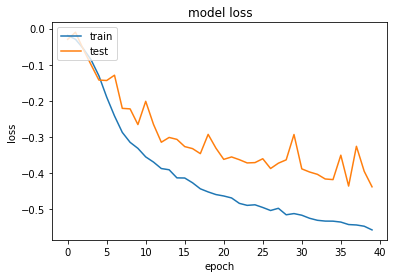

{'val_loss': [-0.029754184608189564, -0.01018368242396833, -0.05751716213900176, -0.10017871041152929, -0.1424582696575358, -0.14368337190442626, -0.12904996126947174, -0.22077437340434353, -0.2221723025031141, -0.2655887921539756, -0.2012557815981213, -0.2651505991945937, -0.31447191727155327, -0.3012143842180671, -0.30656402683087847, -0.32652441297849183, -0.33210548279785124, -0.3460069287498042, -0.29274264844262676, -0.3308996642991513, -0.3618717705759693, -0.355155044584357, -0.36274522251161245, -0.3717065759911214, -0.370837506471028, -0.36013252315078687, -0.38719227905482556, -0.37244255191084685, -0.3631920612235266, -0.2930900771161356, -0.3881866629484781, -0.39685273006338057, -0.4032627532276677, -0.4161115213658723, -0.41787042358224336, -0.35033010081604143, -0.43572909047201175, -0.3257480473131747, -0.39503339499858253, -0.43777152471916825], 'val_f1': [0.05769518142388464, 0.02009784458570794, 0.10723229567959623, 0.1790755184073797, 0.24374640743071968, 0.2396007

In [32]:
# list all data in history

print(result.history.keys())


# summarize history for loss
plt.plot(result.history['loss'])
plt.plot(result.history['val_loss'])
plt.title('model loss') #Benennung des Grafen
plt.ylabel('loss')  #Benennung der y-Achse
plt.xlabel('epoch') #Benennung der x-Achse
plt.legend(['train', 'test'], loc='upper left')
plt.show()

print(result.history)

In [33]:
# evaluate on the test dataset
testInputPath = dsPath + '/test/images'
testOutputPath = dsPath + '/test/masks'

testGen = loadData(testInputPath, testOutputPath, batch_size)

In [34]:
model.evaluate_generator(testGen, steps=test_size/batch_size ,verbose=1 )

Found 3922 images belonging to 1 classes.
Found 3922 images belonging to 1 classes.
(32, 224, 224, 1)
(32, 224, 224, 1)
123/122 [==============================] - 16s 131ms/step


[-0.4453386897520409,
 0.6065994653696919,
 0.4453386897520409,
 0.6823134687954768,
 0.5652145803856157,
 0.16672384015140576]

In [15]:
predict = model.predict_generator(testGen, steps=test_size/batch_size, verbose=1)

123/122 [==============================] - 16s 131ms/step


In [34]:
print (predict.shape)

(3922, 224, 224, 1)


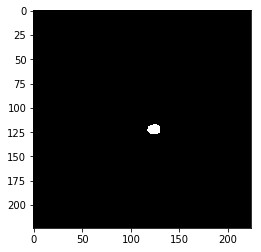

In [16]:
b = 0
i = 555
plt.imshow(predict[i, ..., 0], cmap = 'gray')
plt.show()
#plt.imshow(testGen[b][i, ..., 0], cmap='gray')
#plt.show()